## Create 2D Datasets

2D data is easy to anayze, because we can plot an arbitray large batch of a distribution at once, which is not possible for image data - you can only plot one image at a time.

We want to have a dataset with a few modes - we chose 4. Therefore we sample from a Gaussian Mixture that has centers the centers $\{(-1, -1), (-1, 1), (1, -1), (1, 1)\}$.
A Gaussian mixture has connected support - the pdf is greater than zero everywhere (although small far away from the centers). We are also interested in learning distributions with unconnected support, such as images of faces with and without glasses. So we change the distribution and reject all samples that have a distance larger than 0.2 from their respective  centers.

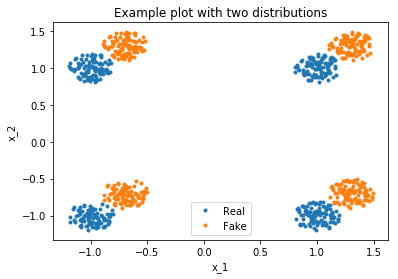

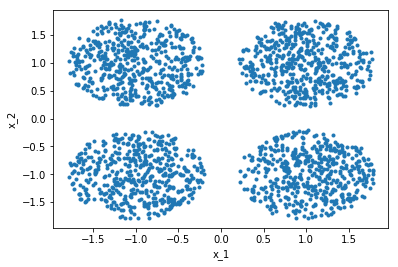

In [12]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

na = None

def show_2d(x_real, x_fake=None, title=None, space='x'):
    plt.plot(x_real[:, 0], x_real[:, 1], '.', label='Real')
    if x_fake is not None:
        plt.plot(x_fake[:, 0], x_fake[:, 1], '.', label='Fake')
        plt.legend()
    if title is not None:
        plt.title(title)
    plt.xlabel(space+'_1')
    plt.ylabel(space+'_2')
    plt.show()

    

def get_mode(center, n_per_mode, r):
    samples = np.random.normal(center, r, size=(3*n_per_mode, 2))
    dist = np.linalg.norm(samples-center[na,...], axis=1)
    return samples[dist<r][:n_per_mode]

def generate_2d(n_per_mode, radius=0.2):
    centers = [
        np.array([-1, -1]),
        np.array([-1, 1]),
        np.array([1, -1]),
        np.array([1, 1])
    ]
    return np.concatenate([get_mode(c, n_per_mode, radius) for c in centers], axis=0)

x = generate_2d(100)
show_2d(x, x+0.3, 'Example plot with two distributions')
show_2d(generate_2d(500, 0.8))

In [2]:
# Now we create the one and only version of thsi dataset that we are going to use for all experiments
# don't execute again, it overwrites the saved data
# np.save('data/2d.npy', generate_2d(500))

The dataset can be loaded now:

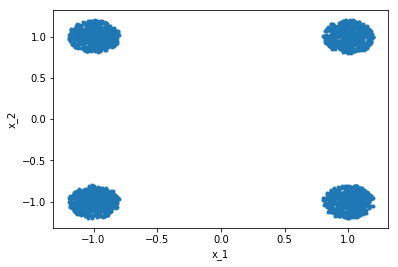

(2000, 2)

In [3]:
x = np.load('data/2d.npy')
show_2d(x)
x.shape

Now let's train a GAN to sample from this distribution. We can analyze the training by repeatedly checking the following questions:
1. how does the learned distribution change over time?
2. what is $ D(G(z)) $ for a grid of $z$s?
3. what is the mapping $G$? We can associate each point $z$ with a color $C(G(z))$, where the color mapping $C$ is e.g. an rgb color: $(x_1, x_2) -> rgb(n(x_1), n(x_2), 0) $ where $n$ is an affine function.

Let's create the plot functions we can use to analyze our GAN one by one. During training, we can pass it as callbacks that are executed after each epoch, to see how training evolves.

### The Generator

In [4]:
import keras
from keras import layers
from keras.models import Model


class Generator():
    
    def __init__(self, inputs=keras.Input(shape=[2])): 
        self.layers = [
            layers.Dense(4, use_bias=False, input_shape=(2,)),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Dense(4, use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Dense(2)
        ]
        
        self.model = Model(inputs=inputs, outputs=self.forward(inputs))
        self.optimizer = keras.optimizers.Adam(1e-4)
        
    def forward(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x
        
    
    def loss(self, D):
        # D: keras model
        def l(y_target, x_fake):
            # y_target: always 1
            y_fake = D(x_fake)
            return keras.losses.binary_crossentropy(y_target, y_fake)
        return l
    
    def __call__(self, *args, **kwargs):
        return self.model.predict(*args, **kwargs)

    
G = Generator()            
    

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


### Show the learned distribution

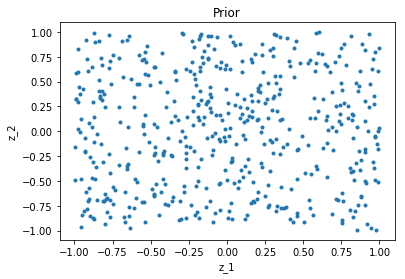

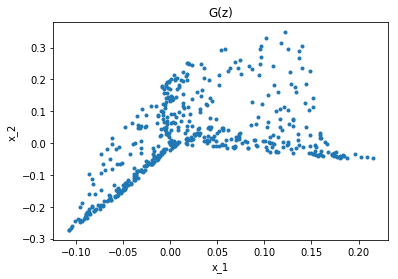

In [5]:
class Uniform():
    def __init__(self, d=2):
        self.d = d
    
    def __call__(self, n):
        return np.random.uniform(low=-1, high=1, size=(n, self.d))

uniform = Uniform()

def show_learned_distribution(prior, G):
    z = prior(500)
    show_2d(z, title='Prior', space='z')
    show_2d(G(z), title='G(z)')

show_learned_distribution(uniform, G)

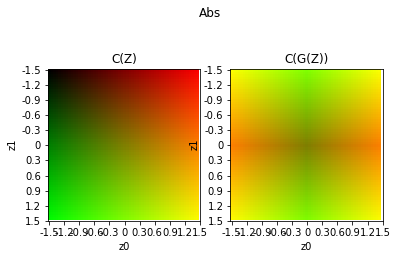

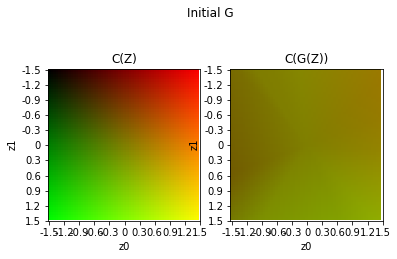

In [6]:
def make_grid():
    ticks = np.arange(-1.5, 1.5, 0.05)
    return np.dstack(np.meshgrid(ticks, ticks)).reshape(-1, 2)

def grid_labels():
    return range(0, 61, 6), [f"{i/50:.2g}" for i in range(-75, 76, 15)] 

grid = make_grid()

def colors_of(x):
    c = np.zeros([x.shape[0], 3])
    c[:, :2] = (x+1.5)/3
    return np.clip(c, 0, 1)

def color_plot(mapping, title=None):
    z = make_grid()
    x = mapping(z)
    
    fig, ax = plt.subplots(ncols=2)
    
    ax[0].imshow(colors_of(z).reshape(60, 60, 3))
    ax[0].set_title('C(Z)')
    ticks, labels = grid_labels()
    ax[0].set_xticks(ticks)
    ax[0].set_xticklabels(labels)
    ax[0].set_yticks(ticks)
    ax[0].set_yticklabels(labels)
    ax[0].set_xlabel('z0')
    ax[0].set_ylabel('z1')
    
    ax[1].imshow(colors_of(x).reshape(60, 60, 3))
    ax[1].set_title('C(G(Z))')
    ax[1].set_xticks(ticks)
    ax[1].set_xticklabels(labels)
    ax[1].set_yticks(ticks)
    ax[1].set_yticklabels(labels)
    ax[1].set_xlabel('z0')
    ax[1].set_ylabel('z1')
    
    if title is not None:
        fig.suptitle(title)
    
    plt.show()
    
color_plot(lambda x: np.abs(x), 'Abs')
color_plot(G, 'Initial G')
    
    

### Discriminator

In [7]:
class Discriminator():
    def __init__(self, inputs=keras.Input(shape=[2])): 
        self.layers = [
            layers.Dense(4, use_bias=False, input_shape=(2,)),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Dense(4, use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Dense(1, activation='sigmoid')
        ]
        
        self.model = Model(inputs=inputs, outputs=self.forward(inputs))
        self.optimizer = keras.optimizers.Adam(1e-4)
        
    def forward(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x
    
    def __call__(self, *args, **kwargs):
        return self.model.predict(*args, **kwargs)

D = Discriminator()

### Plot $D(G(z))$ over a grid of $z$s

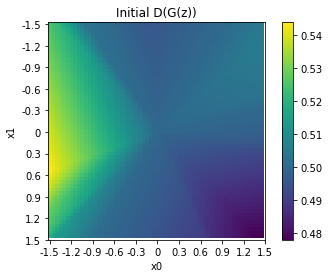

In [8]:
def score_over_z(G, D, title=None):
    z = make_grid()
    dgz = D(G(z))
    plt.imshow(dgz.reshape(60, 60))
    ticks, labels = grid_labels()
    plt.xticks(ticks, labels)
    plt.yticks(ticks, labels)
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
score_over_z(G, D, "Initial D(G(z))")

# GAN Training

We have everything prepared, now we can train our GAN. We want to keep it modular with respect to the `Generator` and `Discriminator` class as well as the `prior` function, so that we can use it on another dataset like MNIST as well, or test different priors.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_37 (Dense)             (None, 4)                 8         
_________________________________________________________________
batch_normalization_25 (Batc (None, 4)                 16        
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 4)                 0         
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 16        
_________________________________________________________________
batch_normalization_26 (Batc (None, 4)                 16        
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 4)                 0         
__________

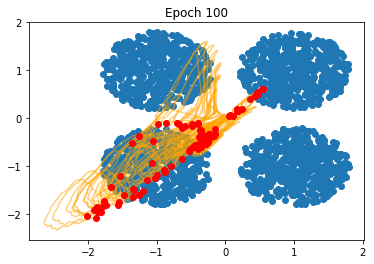

....................................................................................................

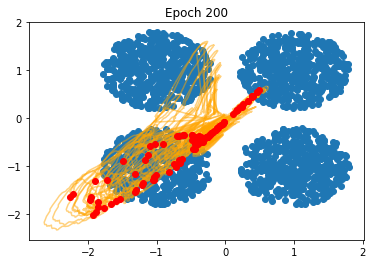

....................................................................................................

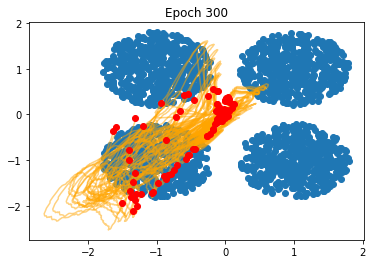

....................................................................................................

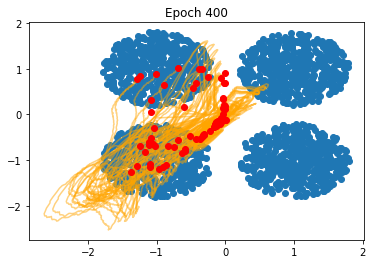

..........................................................................................

In [ ]:
import tensorflow as tf
import time
from keras.models import load_model
from keras import backend as K

def batches(x, batch_size):
    """
    :x: shape (N, d)
    :return: Yields batches
    """
    x = x[np.random.permutation(len(x))][:int(len(x)/batch_size)*batch_size]
    for i in range(0, len(x), batch_size):
        yield x[i:i+batch_size]
        
        
class GAN():
    def __init__(self, prior, G, D):
        self.prior = prior
        
        # create loss and compile G
        g_loss = G.loss(D.model)
        G.model.compile(G.optimizer, g_loss)
        self.G = G
        
        # same for D
        D_loss = keras.losses.binary_crossentropy
        D.model.compile(D.optimizer, D_loss)
        self.D = D
        
    # Compiling the function
    def train_step(self, x_real, d_per_g_updates):
        n = x_real.shape[0]
        z = self.prior(n)
        
        self.G.model.train_on_batch(z, np.ones(n))
        
        # create a batch of fakes and reals, with corresponding labels
        for _ in range(d_per_g_updates):
            z = self.prior(n)
            x_fake = self.G(z)
            x_mix = np.concatenate([x_fake, x_real], axis=0)
            y_target = np.concatenate([np.zeros(n), np.ones(n)], axis=0)
            # train D
            self.D.model.train_on_batch(x_mix, y_target)

    def fit(self, x, epochs, file_prefix, callbacks=[], callback_every=10, d_per_g_updates=5):
        """
        x: samples from the real distribution
        epochs: how many epochs to train
        file_prefix: saves the model to ./models/file_prefix<_g.npy and _d.npy>
        callbacks: [f(z_at_epoch), ...] to execute at the end of each epoch
        callback_every: int, number of epochs after that the callbacks are executed
        returns: z_at_epoch: [G_at_epoch_i(fixed_z)) for i in range(epochs)]
        """
        z = self.prior(100)
        z_at_epoch = [self.G(z)]
        for epoch in range(epochs):
            start = time.time()

            for x_real in batches(x, 128):
                self.train_step(x_real, d_per_g_updates)
            print('.', end='')
            
            if (epoch + 1) % callback_every == 0:
                for callback in callbacks:
                    callback(z_at_epoch)

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                self.save(file_prefix)
            
            z_at_epoch += [self.G(z)]
            #print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
            
        return z_at_epoch
    
    def save(self, file_prefix):
        self.G.model.save(f"{file_prefix}_g.h5")
        self.D.model.save(f"{file_prefix}_d.h5")
    
    @staticmethod
    def load(file_prefix, prior):
        G = load_model(f"{file_prefix}_g.h5")
        D = load_model(f"{file_prefix}_d.h5")
        return GAN(prior, G, D)
    

gan = GAN(uniform, Generator(), Discriminator())
x = generate_2d(500, 0.8)


def plot_stuff(z_at_epoch):
    epoch = len(z_at_epoch)
    score_over_z(gan.G, gan.D, f"D(G(z)) after {epoch} epochs")
    color_plot(gan.G, f"G at epoch {epoch}")
    show_2d(x, gan.G(gan.prior(400)))
    
def show_evolving(z_at_epoch):
    t = np.stack(z_at_epoch, axis=0)
    plt.clf()
    plt.plot(x[:,0], x[:,1], 'o')
    for p in range(t.shape[1]):
        plt.plot(t[:,p,0], t[:,p,1], alpha=0.5, color='orange')
    plt.plot(t[-1,:,0], t[-1,:,1], 'o', color='red')
    plt.title(f"Epoch {len(z_at_epoch)}")
    plt.show()

print(gan.G.model.summary())
print(gan.D.model.summary())

z_at_epoch = gan.fit(x, 10000, 'models/2d_uniform', [show_evolving], 100)


In [ ]:
from keras.utils import plot_model
from IPython.display import Image, display


plot_model(gan.G.model, to_file="plots/2d_G.png")
display(Image("plots/2d_G.png"))
plot_model(gan.D.model, to_file="plots/2d_D.png")
display(Image("plots/2d_D.png"))

DG = Model(inputs=gan.G.model.inputs, outputs=[D.forward(G.model.outputs[0])])
plot_model(DG, to_file="plots/2d_DG.png")
display(Image("plots/2d_DG.png"))